### 如何处理不规则房间？

In [2]:
from pathlib import Path
from scipy import signal
import numpy as np
from mpl_toolkits import mplot3d
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from stl import mesh
%matplotlib widget  

import soundfile as sf

def help_view3D(room3D,title=None):#,xlim=[-0.1, 10],ylim=[-0.1, 14],zlim=[-0.1, 7],title=None):
    #绘制房间
    fig, ax = room3D.plot()
    if title is not None:
        ax.set_title(title)
        fig.suptitle(title)      # 整个figure的标题（窗口最上方）
    ax.view_init()
    # ax.set_xlim(xlim)
    # ax.set_ylim(ylim)
    # ax.set_zlim(zlim)
    ax.set_xlabel("x(m)")
    ax.set_ylabel("y(m)")
    ax.set_zlabel("z(m)")
    fig.set_size_inches(8, 6)


stl_path = Path("cinema.stl")

def get_room_bounds(room):
    """获取房间的边界信息"""
    # 从墙体信息中提取边界
    all_points = []
    for wall in room.walls:
        # wall.corners包含墙体的角点坐标
        all_points.extend(wall.corners.T)
    
    all_points = np.array(all_points)
    
    bounds = {
        'x_min': np.min(all_points[:, 0]),
        'x_max': np.max(all_points[:, 0]),
        'y_min': np.min(all_points[:, 1]),
        'y_max': np.max(all_points[:, 1]),
        'z_min': np.min(all_points[:, 2]),
        'z_max': np.max(all_points[:, 2])
    }
    
    print("房间边界:")
    for key, value in bounds.items():
        print(f"  {key}: {value:.2f}")
    
    return bounds

加载STL文件

In [3]:
the_mesh = mesh.Mesh.from_file(stl_path)

ntriang, nvec, npts = the_mesh.vectors.shape
size_reduc_factor = 10.0  

定义房间相关参数

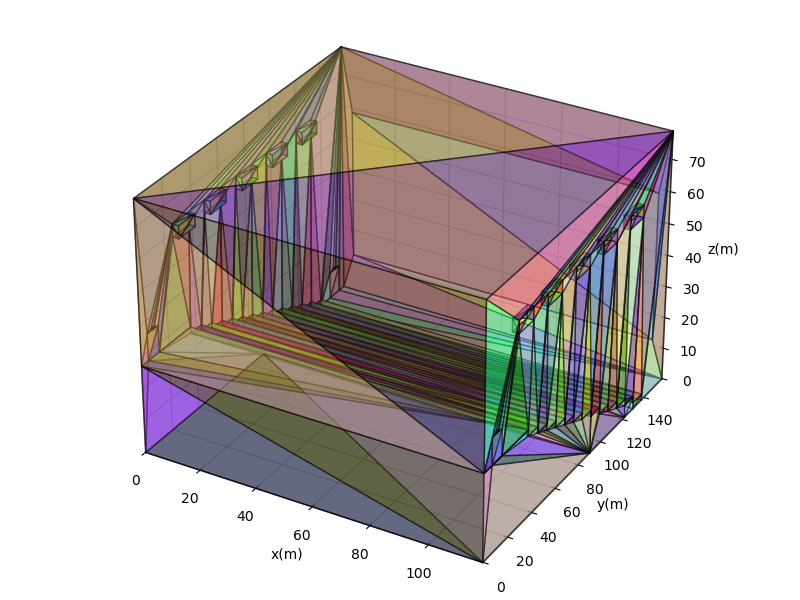

In [4]:
audio,sr = sf.read('../wavs/speech_testing_mono_2205k.wav')

material = pra.Material(energy_absorption=0.6, scattering=0.1)
 # create one wall per triangle
walls = []
for w in range(ntriang):
    walls.append(
        pra.wall_factory(
            the_mesh.vectors[w].T / size_reduc_factor,
            material.energy_absorption["coeffs"],
            material.scattering["coeffs"],
        )
    )
cinema = (
        pra.Room(
            walls,
            fs=sr,
            max_order=0,
            ray_tracing=True,
            air_absorption=True,
        )
    )

help_view3D(cinema)

In [5]:
room_bounds = get_room_bounds(cinema)

房间边界:
  x_min: -0.12
  x_max: 118.02
  y_min: 0.00
  y_max: 157.48
  z_min: 0.00
  z_max: 78.74


添加声源和观众

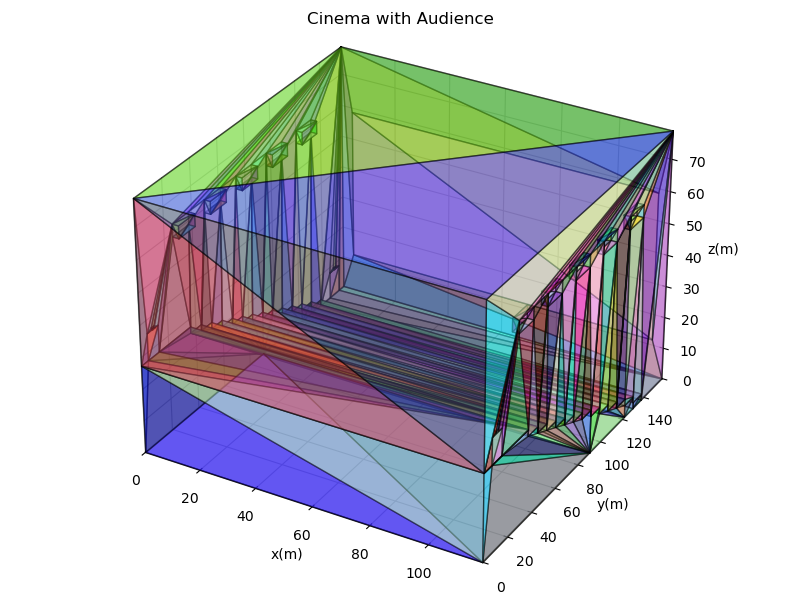

In [6]:
'''添加接收端'''
# 把观众作为麦克风阵列加入房间 (可用于后续 RIR / 渲染)
x_coordinates = [25,50,75, 100]
y_coordinates = [42,   62 ,  90]
z_coordinates = [25,   22 ,  15]

audience = np.array([[25,42,25],[25,62,22],[25,90,15],
                     [50,42,25],[50,62,22],[50,90,15],
                     [75,42,25],[75,62,22],[75,90,15],
                     [100,42,25],[100,62,22],[100,90,15],
]).T   # → (3, 12)

mics = pra.MicrophoneArray(audience, cinema.fs)
cinema.add_microphone_array(mics)
help_view3D(cinema,title="Cinema with Audience")


=============== 验证声源位置 ===============
声源 1 [ 35. 140.  35.] - 无效，尝试调整...
房间边界:
  x_min: -0.12
  x_max: 118.02
  y_min: 0.00
  y_max: 157.48
  z_min: 0.00
  z_max: 78.74
  调整后的位置 [ 35. 140.  35.] - 有效
声源 2 [ 60. 140.  35.] - 有效
声源 3 [ 85. 140.  35.] - 有效
声源 4 [ 60. 140.  40.] - 有效
声源 5 [ 60. 150.  25.] - 有效
声源 6 [ 3. 80. 50.] - 无效，尝试调整...
房间边界:
  x_min: -0.12
  x_max: 118.02
  y_min: 0.00
  y_max: 157.48
  z_min: 0.00
  z_max: 78.74
  调整后的位置 [ 3. 80. 50.] - 仍然无效，跳过此位置
声源 7 [117.  80.  50.] - 有效
声源 8 [40. 65. 30.] - 有效
声源 9 [80. 65. 30.] - 有效
声源 10 [ 40. 110.  30.] - 无效，尝试调整...
房间边界:
  x_min: -0.12
  x_max: 118.02
  y_min: 0.00
  y_max: 157.48
  z_min: 0.00
  z_max: 78.74
  调整后的位置 [ 40. 110.  30.] - 有效
声源 11 [ 80. 110.  30.] - 无效，尝试调整...
房间边界:
  x_min: -0.12
  x_max: 118.02
  y_min: 0.00
  y_max: 157.48
  z_min: 0.00
  z_max: 78.74
  调整后的位置 [ 80. 110.  30.] - 有效
声源 12 [ 3.  5. 79.] - 无效，尝试调整...
房间边界:
  x_min: -0.12
  x_max: 118.02
  y_min: 0.00
  y_max: 157.48
  z_min: 0.00
  z_max: 78

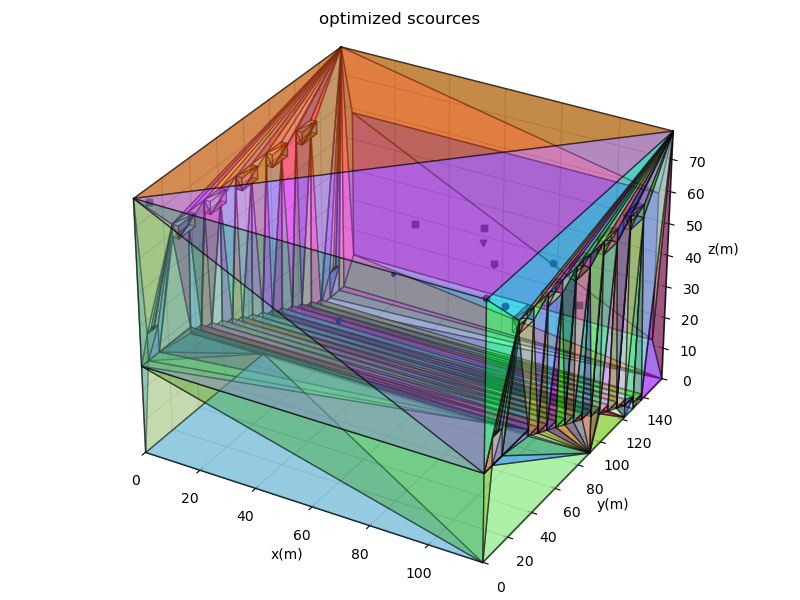

In [9]:
'''添加声源'''


def validate_and_adjust_positions(room, positions, position_type="位置"):
    """验证位置是否在房间内，如果不在则调整"""
    valid_positions = []
    
    for i, pos in enumerate(positions):
        if room.is_inside(pos):
            print(f"{position_type} {i+1} {pos} - 有效")
            valid_positions.append(pos)
        else:
            print(f"{position_type} {i+1} {pos} - 无效，尝试调整...")
            
            # 获取房间边界
            bounds = get_room_bounds(room)
            
            # 调整策略：将坐标限制在房间边界内，并向内收缩一定距离
            margin = 2.0  # 向内收缩2个单位，避免边界问题
            
            adjusted_pos = pos.copy()
            adjusted_pos[0] = np.clip(pos[0], bounds['x_min'] + margin, bounds['x_max'] - margin)
            adjusted_pos[1] = np.clip(pos[1], bounds['y_min'] + margin, bounds['y_max'] - margin)
            adjusted_pos[2] = np.clip(pos[2], bounds['z_min'] + margin, bounds['z_max'] - margin)
            
            # 再次验证调整后的位置
            if room.is_inside(adjusted_pos):
                print(f"  调整后的位置 {adjusted_pos} - 有效")
                valid_positions.append(adjusted_pos)
            else:
                print(f"  调整后的位置 {adjusted_pos} - 仍然无效，跳过此位置")
    
    return np.array(valid_positions)


sources = np.array([
    # 主声道 
    [35., 140., 35.],    # 左声道
    [60., 140., 35.],    # 中置声道  
    [85., 140., 35.],    # 右声道

    # 上声道
    [60., 140., 40.],    # 上声道(主声道上方)
    # 低频声道
    [60., 150., 25.],    # 低音炮(主声道下方)

    # 环绕声道 (减少数量，避免过度混响)
    [3., 80., 50.],   # 左环绕
    [117., 80.,50.],   # 右环绕

    #天花板
    [40., 65., 30.],    #左后
    [80., 65., 30.],    #右后
    [40., 110., 30.],    #左前
    [80., 110., 30.],    #右前

    #后置声道
    [3.,5.,79] ,     #左后
    [117.,5.,79] ,     #右后

])

print("\n=============== 验证声源位置 ===============")
valid_sources = validate_and_adjust_positions(cinema, sources, "声源")
print("\n===============   添加声源   ===============")
for i, pos in enumerate(valid_sources):
    try:
        if i < 4:  # 主声道使用原始信号
            cinema.add_source(pos, signal=audio*5)
            print(f"成功添加主声道 {i+1}: {pos}")
        elif i < 5:  # 低音炮使用低通滤波的信号
            sos = signal.butter(4, 200, btype='low', fs=sr, output='sos')
            filtered_audio = signal.sosfilt(sos, audio) 
            cinema.add_source(pos, signal=filtered_audio)
            print(f"成功添加低音炮: {pos}")
        elif i < 7:  # 环绕声道使用降低增益的信号
            cinema.add_source(pos, signal=audio )
            print(f"成功添加环绕声道 {i-4}: {pos}")
        elif i < 11:  # 天花板使用降低增益的信号
            cinema.add_source(pos, signal=audio )
            print(f"成功添加天花板声道 {i-6}: {pos}")
        else:  # 后置使用降低增益的信号
            cinema.add_source(pos, signal=audio )
            print(f"成功添加后置声道 {i-10}: {pos}")
    except Exception as e:
        print(f"添加声源 {i+1} 失败: {e}")

help_view3D(cinema, title="optimized scources")




每个扬声器到观众的单位脉冲响应

In [10]:
'''绘制单位脉冲响应的函数，输入房间，声源索引和麦克风索引'''
def help_view_RIR(room3D,source_index,mic_index):
    plt.figure(figsize=(10, 6))
    rir = room3D.rir[mic_index][source_index]
    plt.plot(np.arange(len(rir)) / room3D.fs, rir)
    plt.xlabel("Time / s"); plt.ylabel("Amplitude")
    plt.title(f"RIR: Source {0}-> Audience {0}")
    plt.grid(True)
    plt.xlim(0,14)
    plt.show()

cinema.set_ray_tracing(
    n_rays=2000,           # 减少射线数量
    receiver_radius=0.25,   # 稍微减小接收半径
    energy_thres=1e-4,     # 提高能量阈值，过滤弱反射
    hist_bin_size=64/sr,   # 减小时间分辨率
    time_thres=0.5         # 设置时间阈值，截断过长的混响尾巴
)
cinema.compute_rir()
help_view_RIR(cinema,source_index =0,mic_index =0)

ValueError: zero-size array to reduction operation maximum which has no identity

所有扬声器影响之和

In [ ]:

def pad_center(arr: np.ndarray, target_len: int) -> np.ndarray:
    """把 1-D 数组 arr 居中放进目标长度数组，左右补零。"""
    out = np.zeros(target_len, dtype=arr.dtype)
    offset = (target_len - len(arr)) // 2          # 左边留多少空位
    out[offset: offset + len(arr)] = arr
    return out

mic_id   = 0                     # 选第 1 位观众
n_src    = cinema.n_sources      # ← 这里就是 10
max_len  = max(len(cinema.rir[mic_id][s]) for s in range(n_src))

stacked = np.stack([
    pad_center(cinema.rir[mic_id][s], max_len)  # 每条都补到 max_len
    for s in range(n_src)
])

rir_sum = stacked.sum(axis=0)    # (n_src, max_len) → (max_len,)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(rir_sum)) / cinema.fs, rir_sum)
plt.xlabel("Time / s"); plt.ylabel("Amplitude")
plt.title(f"RIR of First Audience")
plt.grid(True)
plt.xlim(0,14)
plt.show()